# Busqueda del Centro de Masa de la Densidad de Fuentes de Corriente

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
muacamuaca=open("DatosActividadEpilepticaSelectos.bin", "r")

IOStream(<file DatosActividadEpilepticaSelectos.bin>)

In [2]:
formaarray=(64,64,9101)

(64,64,9101)

In [3]:
Datos=read(muacamuaca, Float64, formaarray);

In [4]:
tmax=formaarray[3]


9101

In [5]:
close(muacamuaca)

No todos los datos son interesentas. La actividad se concentra en los siguientes cuadros.

In [6]:
#No todo es interesante. 
Datos=Datos[:,:,3500:8500]
tmax=size(Datos)[3]
formaarray=(64,64,tmax)

(64,64,5001)

Aquí abajo definimos los filtros que matarán señales saturadas y pondran toda señal debajo de cierto umbral en cero.

In [7]:
function umbral(x)
    result=((abs(x)>500) ? 0 : x)
end;

function aplastar(x)
    result=((abs(x)<60) ? 0 : x)
end;

function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

UnNormGauss (generic function with 1 method)

In [8]:
function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3 sigmas.
    #Bien, veamos como chingaos le ponemos "padding" a las convoluciones.
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    result=result*a/b
    return result
end
    

GaussSuavizar (generic function with 1 method)

In [1]:
using PyPlot

INFO: Loading help data...


In [10]:
ParaMostrar=reshape(Datos[50,55,:],tmax) 
tiempo=1:5001

1:5001

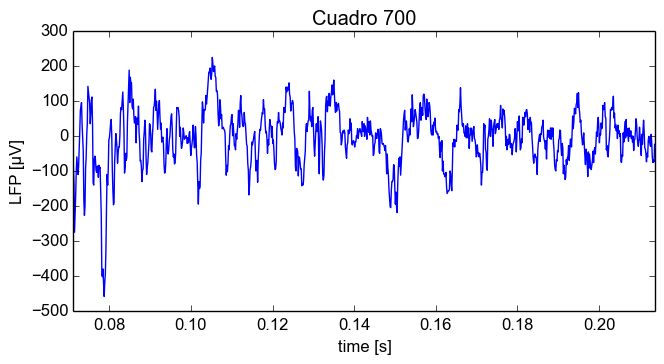

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c2ee1bc50>

In [27]:
a=700
tit="Cuadro $a"
figure(figsize=(7.5,3.5))
PyPlot.xlim(500/7022,1500/7022)
xlabel("time [s]")
ylabel("LFP [µV]")
title(tit)
plot(tiempo/7022,ParaMostrar)

In [12]:
writedlm("EjemploPlaticaCrudo01.dat", ParaMostrar[500:1500])

In [13]:
ParaMostrarSuave=GaussSuavizar(ParaMostrar, 3);

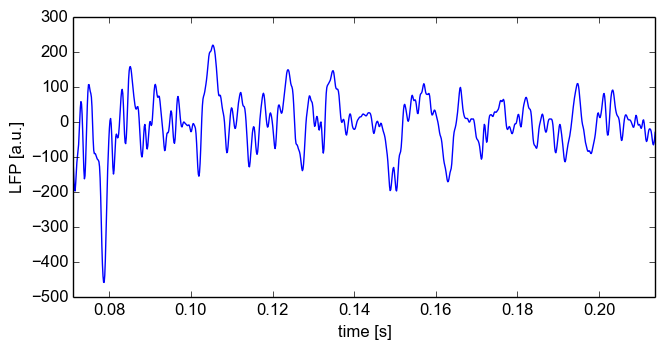

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c2f2b5c90>

In [14]:
figure(figsize=(7.5,3.5))
PyPlot.xlim(500/7022,1500/7022)
xlabel("time [s]")
ylabel("LFP [a.u.]")
plot(tiempo/7022,ParaMostrarSuave)

In [15]:
writedlm("EjemploPlaticaSuave01.dat", ParaMostrarSuave[500:1500])

In [16]:
Chumbaganga=zeros(Datos);
for j=1:64, k=1:64
    #if(MascaraOtsu[j,k]==1)
        Chumbaganga[j,k,:]=GaussSuavizar(reshape(Datos[j,k,:],tmax),3)
    #end    
end

La umbralización de Otsu la vamos a aplicar sobre la desviación estándar en la señal de cada electródo. Para ello, primero quitamos los canales saturados y después calculamos este valor.

In [2]:
figsize=(3.5,3.5)
#fig, ax=PyPlot.subplots()
a=700
b=print(a/7022, "f10.2")
cax=imshow(Chumbaganga[:,:,700], cmap="seismic", origin="upper", vmin=-200,vmax=200)
cb=colorbar(cax)
cb[:set_label]("tururu")
title("$b s")
savefig("LCF01-$a.png")

0.09968669894616919f10.2

LoadError: imshow not defined
while loading In[2], in expression starting on line 5

In [18]:
GaussianKernel=readdlm("GaussianMatrix.dat");
function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #piensa como normalizar
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [19]:
LaplacianKernel=zeros(3,3);
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo, k=2:ancho
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [20]:
Guara=Chumbaganga[:,:,700]
GaussGuara=GaussianSmooth(Guara)
LapGuara=DiscreteLaplacian(Guara)
LapGausGuara=DiscreteLaplacian(GaussGuara)

64x64 Array{Float64,2}:
 -5322.19      180.421     931.982      …  128.787     929.198     0.0
   190.304    1171.07      621.715          86.8252    630.749     0.0
   935.764     617.364     184.567          15.4347    203.986     0.0
   129.677      81.2473     12.5854         10.9015     17.776     0.0
   -26.8436     12.5701      5.88836        -6.79347    -9.48253   0.0
   -28.3432     17.0421     22.9905     …    1.23073    12.2565    0.0
   -25.3429     -5.79972     2.34111         4.39524    20.5684    0.0
    11.9524     -7.70001   -12.4445         -4.89079     2.19993   0.0
    24.9883      0.836386   13.2749         -5.31011   -14.9538    0.0
    19.1513    -19.7855     -1.2194         -9.83437   -26.9743    0.0
    12.8722    -15.6431     -7.17288    …  -24.4451    -30.3664    0.0
     3.58952   -13.4921      0.0861296       3.51171   -19.2244    0.0
    14.3751    -20.7219    -12.9876         44.8607      9.80707   0.0
     ⋮                                  ⋱            

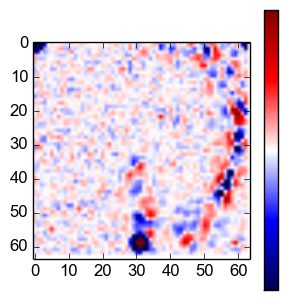

In [21]:
figure(figsize=(3.5,3.5))
imagen=imshow(-LapGausGuara, cmap="seismic", origin="upper", vmin=-150, vmax=150)
bubu=colorbar(imagen, ticks=[-200, 200])
savefig("CSD01.png")

In [22]:
writedlm("EjemploPlaticaCSD700.dat", -LapGausGuara)

In [23]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

vecindad8 (generic function with 1 method)

In [24]:
CSD=-LapGausGuara
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    
    for j=1:64, k=1:64
        if(CSD[j,k]<-0.0)      
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
        elseif(CSD[j,k]>0.0) 
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                    deleteat!(listaneg, indexin({v}, listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
            masalocal=CSD[j,k]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMNegLapla-700.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                    deleteat!(listapos, indexin({v}, listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
            masalocal=CSD[j,k]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMPosLapla-700.dat"
    writedlm(zacatlan, centrosdemasapos)


In [5]:
a=zeros(4,1)

4x1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0

In [27]:
EjemploCentrosCSDPos=readdlm("GarbageCollector/CMPosLapla-700.dat")
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSD[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CMNegLapla-700.dat")
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("GarbageCollector/CSD-700.dat");

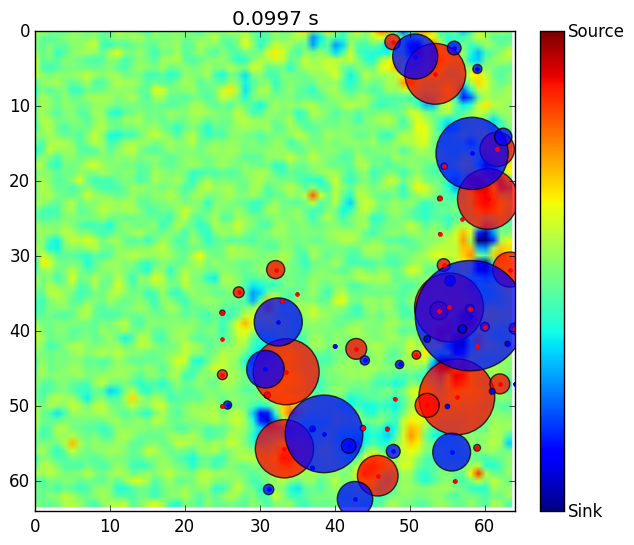

In [35]:
t=700
seg=round(t/7022, 4)
titulo="$seg s"
PyPlot.xlim(0,64)
PyPlot.ylim(64,0)
otraimagen=imshow(CSDEjemplo, cmap="jet", origin="upper", vmin=-150, vmax=150)
#cb=colorbar(otraimagen)
cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04 )
cb[:set_ticklabels]([{"Sink"}, {"Source"}])
scatter(xxpos,yypos, s=valorpos, alpha=0.75, c="r")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.75, c="b")
plot(xxpos,yypos, "r.")
plot(xxneg, yyneg, "b.")
title(titulo)
savefig("EjemploPyPlotCSDCMDijs700.png", dpi=72)
show()